# Broadcast View

IPython Parallel is built on the idea of working with N remote IPython instances.
This means that most of the 'parallelism' when working with N engines
via the DirectView is really implemented in the client.

DirectView methods are all implemented as:

```python
for engine in engines:
    do_something_on(engine)
```

which means that all operations are at least O(N) *at the client*.
This can be really inefficient when the client is telling all the engines to do the same thing,
*especially* when the client is across the Internet from the cluster.

IPython 7 includes a new, experimental *broadcast* scheduler that implements the same message pattern,
but sending a request to any number of engines is O(1) in the client.
It is the *scheduler* that implements the fan-out to engines.

With the broadcast view, a client always sends one message to the root node of the scheduler.
The scheduler then sends one message to each of its two branches,
and so on until it reaches the leaves of the tree,
at which point each leaf sends $\frac{N}{2^{depth}}$ messages to its assigned engines.

The performance should be strictly better with a depth of 0 (one scheduler node),
network-wise,
though the Python implementation of the scheduler may have a cost relative to the pure-C default DirectView scheduler. 


This approach allows deplyments to exchange single-message latency (due to increased depth) for parallelism (due to concurrent sends at the leaves).

This trade-off increases the baseline cost for small numbers of engines,
while dramatically improving the total time to deliver messages to large numbers of engines,
especially when they contain a lot of data.

These tests were run with a depth of 2 (4 leaves nodes)

In [1]:
import ipyparallel as ipp

rc = ipp.Client()
direct_view = rc.direct_view()
bcast_view = rc.broadcast_view()

In [3]:
print(f"I have {len(rc)} engines")

I have 64 engines


To test baseline latency, we can run an empty `apply` task with both views:

In [4]:
%timeit direct_view.apply_sync(lambda: None)

1.29 s ± 200 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%timeit bcast_view.apply_sync(lambda: None)

452 ms ± 140 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


With just 64 engines, it takes noticeably longer to complete on the direct view as the new broadcast view.

Sending the same data to engines is probably the pattern that most suffers from this design,
because identical data is duplicated *once per engine* in the client.

We can compare `view.push` with increasing array sizes:

In [7]:
import numpy as np

for n in 16, 64, 256, 512:
    chunk = np.random.random((n, n))
    b = chunk.nbytes
    unit = 'B'
    if b > 1024:
        b //= 1024
        unit = 'kB'
        if b > 1024:
            b //= 1024
            unit = 'MB'
    print(f"{n:4} x {n:4}: {b:4} {unit}")
    print("Direct view")
    %timeit -n 1 direct_view.push({"chunk": chunk}, block=True)
    print("Broadcast view")
    %timeit -n 1 bcast_view.push({"chunk": chunk}, block=True)




  16 x   16:    2 kB
Direct view
913 ms ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Broadcast view
517 ms ± 167 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
  64 x   64:   32 kB
Direct view
995 ms ± 198 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Broadcast view
468 ms ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
 256 x  256:  512 kB
Direct view
1.2 s ± 356 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Broadcast view
686 ms ± 232 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
 512 x  512:    2 MB
Direct view
1.2 s ± 422 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Broadcast view
657 ms ± 144 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Tuning broadcast views

As mentioned above, `depth` is a tuning parameter to exchange latency for parallelism.

This can be set with `HubFactory.broadcast_scheduler_depth` configuration (default: 1).
The number of leaf nodes in the tree is `2^d` where `d` is the depth of the tree ($d=0$ means only a root node).

With a DirectView, the total number of request messages is $ 2 N $ and the number of requests to deliver the first message is 2 (one client->scheduler, one scheduler->engine).

With a Broadcast View, the total number of request messages is

$$
N + 1 + \sum_{i=1}^{d} 2^i
$$


Since we are talking about delivering messages to all engines,
the metric of interest for a 'cold start' is how many messages must the last engine wait for before its message is delivered,
because until that point, at least some of the cluster is idle, waiting for a task.
This is where the parallelism comes into play.

In the DirectView, the message destined for the last engine N must wait for N sends from the client to the scheduler, then again for N sends from the scheduler to each engines, for a total of 2 N sends before the engines gets its message.

In the BroadcastView, we only have to count sends along one path down the tree:

- one send at the client
- two sends at each level of the scheduler
- $\frac{N}/{2^d}$ sends at the leaf of the scheduler

for a total of:

$$
1 + 2^d + \frac{N}{2^d}
$$

sends to get the first message to the last engine (and therefore all engines). This is a good approximation of how deep your scheduler should be based on the number of engines. It is an approximation because it doesn't take into account the difference in cost between a local zmq send call vs a send actually traversing the network and being received.

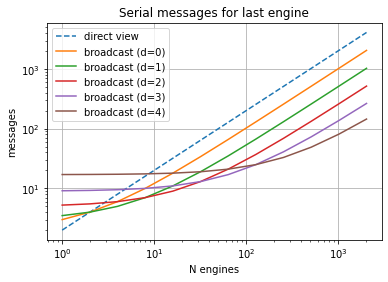

In [57]:
import numpy as np
import matplotlib.pyplot as plt

N = np.logspace(0, 11, 12, base=2, dtype=int)
N

dview_sends = 2 * N

def bcast_sends(N, depth):
    return 1 + (2**depth) + (N / (2**depth))

plt.loglog(N, dview_sends, '--', label="direct view")
for depth in range(5):
    plt.loglog(N, bcast_sends(N, depth), label=f"broadcast (d={depth})")

plt.xlabel("N engines")
plt.ylabel("messages")
plt.title("Serial messages for last engine")
plt.grid(True)
plt.legend(loc=0)

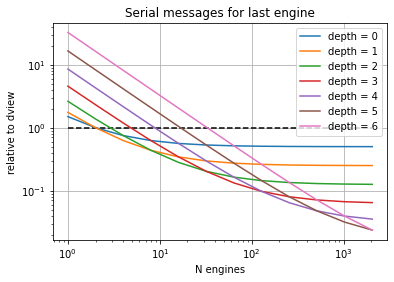

In [58]:
# <!-- plt.semilogx(N, dview_sends, '--', label="direct view") -->
plt.plot(N, [1] * len(N), '--k')
for depth in range(7):
    plt.loglog(N, bcast_sends(N, depth) / dview_sends, label=f"depth = {depth}")

plt.xlabel("N engines")
plt.ylabel("relative to dview")
plt.title("Serial messages for last engine")

plt.grid(True)
plt.legend(loc=0)

## Coalescing replies

The broadcast view changes the number of requests a client sends from one per engine to just one,
however each engine still has its own *reply* to that request.

One of the sources of performance in the client, especially when sending many small tasks,
is contention receiving replies.

The IPython Parallel client receives replies in a background thread.
If replies start arriving before the client is done sending requests,
this can result in a lot of contention and context switching,
slowing down task submission.

Plus, deserializing all these replies can be a lot of work, especially if the only useful information is that it's done.

For this, the broadcast view has a tuning parameter to 'coalesce' replies.
Unlike depth, this parameter is set per-request instead of for the cluster as a whole.

Coalescing reduces the number of replies in the same way that requests are reduced on the way to engines -
by collecting replies at each node, and only sending them along to the next layer up when all engines have replied.

As a result, when coalescing is enabled,
a BroadcastView sends exactly one request and receives exactly one reply,
dramatically reducing the workload and number of events on the client.

In [9]:
bcast_view.is_coalescing = False
%timeit bcast_view.apply_sync(lambda: None)

474 ms ± 217 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
bcast_view.is_coalescing = True
%timeit bcast_view.apply_sync(lambda: None)

362 ms ± 56.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Coalescing has its own trade-offs.
Each send and receive at each level has a cost, but so does waiting to send messages.
Coalescing behaves best when lots of (especially small) replies are going to come at the same time.
If responses are large and/or spread out, the cost of leaving network bandwidth idle will outweigh the savings of reduced message deserialization.